# 

In [1]:
from datetime import date
from pycltools.pycltools import *
from collections import Counter
from pprint import pprint as pp 
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
from random import choice, sample
import pandas as pd
from tqdm import tqdm, trange
import sys
import multiprocessing as mp

# Pandas tweaking
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 20

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pl.rcParams['figure.figsize'] = 30, 5
pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = ['DejaVu Sans']
pl.style.use('ggplot')

In [2]:
jprint("Adrien Leger / EMBL EBI", bold=True, size=150)
jprint("Starting date : 2017-12-12", bold=True, italic=True, size=125)
jprint("Last modification date : {}-{}-{}".format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

# Counting sequences containing all the possible kmers

In [7]:
bases = ["A","T","C","G","X"]
tries = 50
kmer_len_min = 4
kmer_len_max = 9

df = pd.DataFrame(columns = range (kmer_len_min, kmer_len_max+1) , index=range(tries))

for kmer_len in range (kmer_len_min, kmer_len_max+1):
    possibilities = len(bases)**kmer_len
    print (f"Kmer length {kmer_len} = {possibilities} possible kmers")
    for t in range(tries):
        kmers_counter = set()
        kmer = "".join([choice(bases) for _ in range(kmer_len)])
        n_base = 0
        while len(kmers_counter) < possibilities:
            new_base = choice(bases)
            kmer = kmer[1:]+new_base
            kmers_counter.add(kmer)
            n_base+=1
        df.loc[t, kmer_len] = n_base
        
df

Kmer length 4 = 625 possible kmers
Kmer length 5 = 3125 possible kmers
Kmer length 6 = 15625 possible kmers
Kmer length 7 = 78125 possible kmers
Kmer length 8 = 390625 possible kmers
Kmer length 9 = 1953125 possible kmers


,4,5,6,7,8,9
0,4865,26879,171393,1058172,4614442,27253070
1,4318,23755,153554,1086588,5124229,28023991
2,4432,19953,146538,1027405,4943330,31474718
3,3355,29144,135179,1003148,4973237,31507228
4,5287,27005,139783,915360,4863433,28243997
5,4387,23917,171259,905759,5753620,28289453
6,4169,21740,142291,914921,5299859,29136943
7,7683,26965,173777,798812,5039680,30209802
8,4020,21227,158554,955652,4762138,28538511
9,3881,27365,169516,754134,5539101,29496549


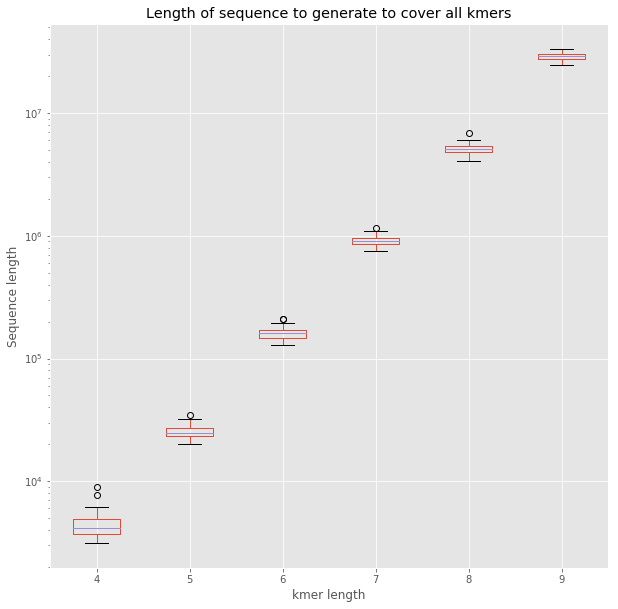

In [9]:
fig, ax = pl.subplots(figsize=(10,10))
_ = df.boxplot(ax=ax)
_ = ax.set_yscale("log")
_ = ax.set_xlabel ("kmer length")
_ = ax.set_ylabel ("Sequence length")
_ = ax.set_title ("Length of sequence to generate to cover all kmers")

# Generate a first draft design

* No homopolymers longer than the 6

* Remove oligo with high secondary struct with RNAfold

* Generate 50 times more than needed

* Sample to get the best kmer diversity with the 20000 oligos in total

## Generate a large number of candidate sequences 

In [70]:
# Define options
bases = ["A","T","C","G"]
n_seq_total = 1000000
seq_len = 50
kmer_len = 7
max_homopolymer_size = 5
out_fasta =  "./sequence_pool.seq"
homopolymer_5_base = "C"
homopolymer_5_len = 6
homopolymer_3_base = "A"
homopolymer_3_len = 11
homopolymer_5 = homopolymer_5_base*homopolymer_5_len
homopolymer_3 = homopolymer_3_base*homopolymer_3_len

# Init values
seq_list = []
kmer_counter = Counter()
possible_kmers = len(bases)**kmer_len
stdout_print (f"Kmer length {kmer_len}\n{possible_kmers} possible kmers\n")

# Create sequence iteratively
with open (out_fasta, "w") as out_fp:
    for n_seq in range(n_seq_total):
        seq = ""
        previous_base = ""
        previous_base_count = 0
        
        for pos in np.arange(seq_len):
            
            bases_choice = bases
            # Prevent long homopolymers
            if previous_base_count >= max_homopolymer_size:
                bases_choice = [b for b in bases_choice if b != previous_base]
                previous_base_count = 0
                
            # # 3 prime exception = different from the leading homopolymer
            if pos == 0:
                bases_choice = [b for b in bases_choice if b != homopolymer_5_base]
                
            # 3 prime exception = different from the trailling homopolymer
            if pos == seq_len-1:
                bases_choice = [b for b in bases_choice if b != homopolymer_3_base]
                
            # ramdomly select one of the possible base
            base = choice(bases_choice)
            
            # Extend the sequence
            seq += base
            previous_base = base
            previous_base_count += 1
            
        # Append sequence to the list and count the diferent kmers in the sequence 
        for k_start, k_end in zip (np.arange(0, seq_len-kmer_len+1), np.arange(kmer_len, seq_len+1)):
            kmer =  seq[k_start:k_end]
            kmer_counter [kmer] +=1
        
        # Add adapters and write in file
        out_fp.write (f"{homopolymer_5}{seq}{homopolymer_3}\n")

stdout_print (f"{len(kmer_counter)} kmers generated")

Kmer length 7
16384 possible kmers
16356 kmers generated

## Verify kmer distribution and the sequence file

In [71]:
s = pd.Series(kmer_counter, name="count")
s.sort_values(ascending=False, inplace=True)
s.to_frame()

,count
ACACGAT,4046
TACTATG,4029
ACAGTGT,4027
GATGATC,4023
TGCGCGC,4016
ACGACAC,4013
AGTAGCT,4013
GCTGCTG,4012
GCTGCGT,4006
AGAGAGT,4005


## Run RNAfold to minimum free energy secondary structures of oligos

In [73]:
infile = "./sequence_pool.seq"
outfile = "./sequence_pool_folded.txt"
queue = "highpri"
thread = 3
mem = 5000

cmd = f"bsub -n {thread} -M {mem} -R 'rusage[mem={mem}]' -q {queue} -oo {outfile} -N RNAfold -i {infile}"
bash (virtualenv="ViennaRNA_2.4.3", cmd=cmd, live="stderr")

Job <5229036> is submitted to queue <highpri>.


## Parse the folded RNA file

In [97]:
seq_dict = {}

with open ("./sequence_pool_folded.txt") as fp:
    score = 0
    seq = ""    
    for line in fp:
        if not seq:
            seq = line.strip()
        else:
            score = line.rpartition(")")[0].rpartition("(")[2].strip()
            if score:
                seq_dict[seq] = float(score)
            seq=""

s = pd.Series(seq_dict, name="MFE")
display(s.head().to_frame())
display(s.describe(percentiles=[0.05,0.10, 0.25, 0.5, 0.75, 0.90, 0.95]).to_frame())

,MFE
CCCCCCAAAAACAAACUCAUGUACACGGUCUAUCCGUUCGGAGUCACUGAUAAUGGAAAAAAAAAAA,-9.5
CCCCCCAAAAACAAAGAUUAGCAGGGCCCUCGCGGCGGAGGUGAGCAAAGCGGUACAAAAAAAAAAA,-8.6
CCCCCCAAAAACAAAGCGGCCGCCCGCAAGUGCCAAGCGCACGGAAGGGGAGAUACAAAAAAAAAAA,-16.6
CCCCCCAAAAACAAAGCGUAACUGUAGGUACUAGACAACUCAGAAUGGAAUCGUAGAAAAAAAAAAA,-2.3
CCCCCCAAAAACAAAGUAGUCGUUCGUGCUGAGCAUAAUAACUACCUAUCCGCCGCAAAAAAAAAAA,-7.9


,MFE
count,1000000.000000
mean,-10.584371
std,4.042456
min,-35.500000
5%,-17.600000
10%,-15.900000
25%,-13.100000
50%,-10.300000
75%,-7.700000
90%,-5.600000


### Filter out the lower decile (with higher folding energy) and count valid kmers

In [98]:
cutoff = -17.6
kmer_counter = Counter()
start_offset = 6
end_offset = 12
kmer_len = 7
valid_seq_list = []

for seq, score in tqdm(seq_dict.items()):
    if score > cutoff:
        valid_seq_list.append(seq)
        for k_start in np.arange(start_offset, len(seq)-kmer_len-end_offset+2):
            k_end = k_start+kmer_len
            kmer =  seq[k_start:k_end]
            kmer_counter [kmer] +=1

stdout_print (f"Number of valid sequences: {len(valid_seq_list)}\n")
stdout_print (f"{len(kmer_counter)} kmers found\n")

s = pd.Series(kmer_counter, name="count")
s.sort_values(ascending=False, inplace=True)
display(s.to_frame())

100%|██████████| 1000000/1000000 [00:37<00:00, 26655.05it/s]

Number of valid sequences: 948364
16356 kmers found


,count
ACACGAU,3936
UAUAGAU,3915
UAGAUAU,3900
UACUAUG,3895
ACGACAC,3884
UAGAUAC,3870
UCUCACU,3868
AUACUAU,3865
UAUAGAC,3863
UACAUCU,3862


In [99]:
outfile = "valid_seq_list.txt"
with open(outfile, "w") as fh:
    for seq in valid_seq_list:
        fh.write(f"{seq}\n")
head(outfile, 5)

# Sample 20 000 Sequences multiple times and analyse kmer composition

We want as many kmers as possible = with the more homogeneous distribution.

In [100]:
infile = "valid_seq_list.txt"
seq_list=[]
with open(infile, "r") as fh:
    for seq in fh:
        seq_list.append (seq.rstrip())

In [101]:
n_seq = len(seq_list)
nseq_per_bundle = 20000
n_bundles = 100
start_offset = 6
end_offset = 12
kmer_len = 7

seq_bundle_list = []
for i in trange(n_bundles):
    seq_id_list = np.random.randint(0, n_seq, size=nseq_per_bundle)
    kmer_counter = Counter()
    for seq_id in seq_id_list:
        seq = seq_list[seq_id]
        for k_start in np.arange(start_offset, len(seq)-kmer_len-end_offset+2):
            k_end = k_start+kmer_len
            kmer = seq[k_start:k_end]
            kmer_counter [kmer] +=1
    
    n_kmers = len (kmer_counter)
    counts = list(kmer_counter.values())
    min_count = np.min (counts)        
    sd_count = np.std (counts)
    max_count = np.max (counts)
    diff = max_count-min_count
    seq_bundle_list.append({"seq_id_list":seq_id_list,"n_kmers":n_kmers,"sd_count":sd_count, "min":min_count, "max":max_count, "diff":diff})

df = pd.DataFrame(seq_bundle_list)
df.sort_values(["min"], inplace=True, ascending=False)
df

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


,diff,max,min,n_kmers,sd_count,seq_id_list
90,104,110,6,16356,16.979431,"[935601, 202962, 207975, 13271, 484905, 15623, 359213, 203098, 666463, 132874, 807653, 450123, 2..."
50,105,110,5,16356,17.175440,"[483084, 925570, 298462, 291015, 942083, 633167, 361788, 585260, 880619, 28059, 723699, 512288, ..."
91,101,106,5,16356,17.220089,"[690683, 77517, 905130, 924595, 602179, 31028, 211202, 35230, 388609, 297217, 694734, 415260, 39..."
79,100,105,5,16356,17.095667,"[208170, 819389, 619904, 431013, 419368, 627067, 727222, 703177, 814646, 797476, 374339, 500597,..."
78,103,108,5,16356,17.149592,"[164257, 409523, 29955, 282512, 28944, 490356, 356423, 126483, 128040, 761524, 851569, 364161, 2..."
65,106,111,5,16356,17.245637,"[439446, 807399, 317488, 62410, 222109, 817875, 733333, 603297, 576043, 364909, 143647, 848265, ..."
42,104,109,5,16356,17.007358,"[169310, 893113, 836680, 112863, 232763, 821011, 486924, 389392, 304784, 942903, 81565, 280119, ..."
44,110,115,5,16356,17.085400,"[722724, 807590, 481732, 377583, 308583, 427746, 311996, 910862, 622906, 629248, 468315, 715161,..."
23,105,110,5,16356,17.202519,"[579790, 50589, 26117, 216232, 428022, 77132, 684872, 447622, 550854, 832829, 111561, 872343, 30..."
49,102,107,5,16356,17.157679,"[687345, 347106, 75064, 26182, 2149, 335831, 487007, 840451, 96704, 40993, 587475, 62065, 371107..."


Works but too slow to scale up

###  Multiprocessing version

In [3]:
def kmer_per_seq_bundle (seq_file, nseq_per_bundle, n_bundles, start_offset, end_offset, kmer_len, min_score, threads):
    """
    Multithreaded function to speed up the analysis
    """
    
    stdout_print ("Parse sequence file\n")
    seq_list=[]
    with open(seq_file, "r") as fh:
        for seq in fh:
            seq_list.append (seq.rstrip()) 
    n_seq = len(seq_list)
    
    stdout_print ("Simulating sequence combination\n")
    # Init Multiprocessing variables
    with mp.Manager() as manager:
        seq_bundle_q = manager.Queue()
        kmer_stat_q = manager.Queue()
        counter_q = manager.Queue()

        # Define sampling process
        make_bundle_args = (n_seq, nseq_per_bundle, n_bundles, seq_bundle_q, threads)
        make_bundle_ps = mp.Process (target=make_bundle_w, args=make_bundle_args)

        # Define kmer count process
        kmer_stat_args = (seq_list, start_offset, end_offset, kmer_len, seq_bundle_q, kmer_stat_q, counter_q, min_score)
        kmer_stat_psl = [mp.Process (target=kmer_stat_w, args=kmer_stat_args) for _ in range (threads)]

        # Define kmer count process
        counter_args = (counter_q, n_bundles, threads)
        counter_ps = mp.Process (target=counter_w, args=counter_args)

        # Start processes
        make_bundle_ps.start()
        for p in kmer_stat_psl: p.start()
        counter_ps.start()

        # Wait for processes to finish
        make_bundle_ps.join()
        for p in kmer_stat_psl: p.join()
        counter_ps.join()
        
        stdout_print ("Unpacking queue to list\n")
        l = queue_to_list (q=kmer_stat_q, total=n_bundles, n_poison_pills=threads)

    stdout_print ("Transform results to dataframe\n")
    df = pd.DataFrame(l)
    df.sort_values(["n_kmers", "min", "max"], inplace=True, ascending=[False, False, True])
    return df
            
def make_bundle_w (n_seq, nseq_per_bundle, n_bundles, seq_bundle_q, threads):
    """"""
    # Create seq_index_list and enqueue
    for entry in np.arange(n_bundles):
        a = list(np.random.randint(0, n_seq, size=nseq_per_bundle))
        seq_bundle_q.put (a)
        
    # Add 1 poison pill per worker thread
    for i in range (threads):
        seq_bundle_q.put (None)

def kmer_stat_w (seq_list, start_offset, end_offset, kmer_len, seq_bundle_q, kmer_stat_q, counter_q, min_score):
    """"""
    # Consume the seq_bundle queue
    for seq_index_list in iter (seq_bundle_q.get, None):
        kmer_counter = Counter()
        # Iterate over sequences of the index list
        for seq_index in seq_index_list:
            seq = seq_list[seq_index]
            # Count kmers in the sequence
            for k_start in np.arange(start_offset, len(seq)-kmer_len-end_offset+2):
                kmer = seq[k_start:k_start+kmer_len]
                kmer_counter [kmer] += 1
        
        # Compute metrics
        n_kmers = len (kmer_counter)
        counts = list(kmer_counter.values())
        sd_count = np.std (counts)
        min_count = np.min (counts)
        max_count = np.max (counts)
        # Add to queue only of min score is high enough 
        if min_count >= min_score:
            kmer_stat_q.put({"seq_id_list":seq_index_list,"n_kmers":n_kmers,"sd_count":sd_count, "min":min_count, "max":max_count})
        counter_q.put(1)
    
    kmer_stat_q.put (None)
    counter_q.put (None)
    
def counter_w (counter_q, n_bundles, threads):
    with tqdm (total=n_bundles, mininterval=0.5) as pbar:
        for _ in range (threads):
            for pill in iter(counter_q.get, None):
                pbar.update(1)

def queue_to_list (q, total, n_poison_pills):
    l=[]
    with tqdm (mininterval=0.5) as pbar:
        for _ in range (n_poison_pills):
            for item in iter(q.get, None):
                l.append (item)
                pbar.update(1)
    return l

In [4]:
df = kmer_per_seq_bundle (
    seq_file = "valid_seq_list.txt",
    nseq_per_bundle = 20000,
    n_bundles = 500000,
    start_offset = 6,
    end_offset = 12,
    kmer_len = 7,
    min_score = 7,
    threads = 20)

display(df.head())

Parse sequence file
Simulating sequence combination


100%|██████████| 500000/500000 [7:38:14<00:00, 18.19it/s]  


Unpacking queue to list


250it [00:09, 25.61it/s]

Transform results to dataframe


,max,min,n_kmers,sd_count,seq_id_list
75,104,7,16356,17.119772,"[648955, 664452, 45728, 540714, 83946, 235287, 258070, 365885, 477466, 665660, 859634, 684021, 3..."
145,104,7,16356,17.167597,"[110559, 220698, 278308, 30092, 179035, 65458, 376441, 229689, 193588, 741755, 96001, 886072, 30..."
205,104,7,16356,17.126817,"[244617, 223010, 126804, 501738, 325979, 70460, 161472, 773211, 278118, 24722, 170904, 810226, 9..."
15,105,7,16356,16.989500,"[365928, 34900, 732487, 20661, 796920, 448784, 191095, 467060, 63865, 665948, 607014, 536820, 57..."
36,105,7,16356,17.115179,"[177702, 77647, 476467, 601756, 368722, 847771, 875048, 807525, 683969, 901857, 54495, 536338, 4..."


In [5]:
outfile = "sampling_simulation_result.df"
df.to_pickle (outfile)

In [16]:
df = pd.read_pickle("sampling_simulation_result.df")
df.sort_values(["n_kmers", "min", "sd_count"], inplace=True, ascending=[True, False, True])
df.head(20)

,max,min,n_kmers,sd_count,seq_id_list
99,110,7,16356,16.773276,"[408286, 622451, 111827, 147290, 341557, 722653, 766347, 522605, 786332, 160366, 70287, 142936, ..."
188,109,7,16356,16.807446,"[718026, 269825, 308173, 776663, 829950, 889491, 800881, 537425, 211284, 11606, 653266, 139565, ..."
245,109,7,16356,16.861818,"[560780, 514929, 878982, 87951, 147413, 840069, 326120, 477424, 802765, 15301, 342105, 759327, 1..."
186,112,7,16356,16.878930,"[148180, 736453, 948261, 581005, 886398, 408762, 716998, 52662, 817345, 24983, 773164, 491839, 6..."
68,105,7,16356,16.885800,"[595209, 916377, 797623, 61023, 400747, 774254, 772454, 103506, 538333, 25739, 310440, 609021, 3..."
1,111,7,16356,16.926612,"[435609, 915343, 357608, 235618, 807393, 338800, 600048, 25754, 180988, 180433, 859329, 947623, ..."
231,110,7,16356,16.931061,"[158663, 472694, 734618, 671454, 371389, 867557, 685284, 875439, 535427, 483531, 284234, 630380,..."
100,109,7,16356,16.939466,"[663204, 864912, 702623, 179472, 735202, 206253, 334668, 90777, 318859, 131265, 143440, 306657, ..."
224,112,7,16356,16.941360,"[322472, 590229, 331531, 165536, 918374, 38205, 496218, 189126, 848097, 95236, 815025, 330594, 3..."
216,106,7,16356,16.951628,"[552971, 202022, 556604, 671912, 109009, 659484, 775246, 404058, 876806, 435306, 50798, 251084, ..."


I will select the line 99 which as 7 minimun occurences of each 7 mers and the lower kmer count sd of all.

In [18]:
# Get the index of the sequence from the winer combination
fn = "sampling_simulation_result.df"
best_index = 99

jprint("Load sampling simulation result", bold=True)
df = pd.read_pickle(fn)
best_values = df.loc[best_index]
print (best_values)
seq_id_list = set(best_values["seq_id_list"])

jprint("Inport all possible sequences", bold=True)
fn = "valid_seq_list.txt"
with open(fn) as fh:
    seq_list = [seq.strip() for seq in fh]

jprint("Select wining sequences and write to output file", bold=True)
fn_txt = "DNA_test_sequence_panel_selection.txt"
fn_fa = "DNA_test_sequence_panel_selection.fa"
with open (fn_txt, "w") as fp_txt, open (fn_fa, "w") as fp_fa:
    for seq_id in seq_id_list:
        seq = seq_list[seq_id]
        seq = seq.replace("U", "T")
        
        fp_txt.write("{}\n".format(seq))
        fp_fa.write(">ref_{}\n{}\n".format(seq_id, seq))

head(fn_fa)

max                                                                                                            110
min                                                                                                              7
n_kmers                                                                                                      16356
sd_count                                                                                                   16.7733
seq_id_list    [408286, 622451, 111827, 147290, 341557, 722653, 766347, 522605, 786332, 160366, 70287, 142936, ...
Name: 99, dtype: object


>ref_917505                                        
CCCCCCTGCGCGTATAGAATGAGCCGCGATTCGTTTCCTATACCCCGCGA 
>ref_65540                                         
CCCCCCAATGGATGAGTGGAGCGGACGGTACGGGTTCTCATACAATATGA 
>ref_98308                                         
CCCCCCGACCCTATAGACACGTCCGGAAGCCTCTGATCCCTGGTCCAATT 
>ref_229381                                        
CCCCCCATGCTGGAAACATGTGCCAATTAGAGACCGCTCTGTCCTTAGAA 
>ref_458756                                        
CCCCCCTGCTTGCAGGCCTAACACTATTTACGTTCACGGCACTCGCAAAA 

